In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tqdm import trange
from nltk.corpus import stopwords
import evaluate
from scipy.sparse import vstack
from sklearn.metrics import confusion_matrix
from nltk.stem import PorterStemmer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from textblob import TextBlob
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
import string
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from scipy.sparse import hstack


/opt/anaconda3/envs/qualifier-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.__version__

'1.26.4'

In [3]:
splits = {'train': 'balanced/jailbreak_dataset_train_balanced.csv', 'test': 'balanced/jailbreak_dataset_test_balanced.csv'}
all_train_df = pd.read_csv("hf://datasets/jackhhao/jailbreak-classification/" + splits["train"]).rename(columns={"prompt": "text", "type": "label"})
test_df = pd.read_csv("hf://datasets/jackhhao/jailbreak-classification/" + splits["test"]).rename(columns={"prompt": "text", "type": "label"})

In [4]:
len(all_train_df)

1044

In [5]:
# shuffle and with random seed for reproducibility and split the data into train and val 0.8/0.2
allall_train_df_X_train = all_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into training (80%) and validation (20%)
train_size = int(0.8 * len(all_train_df))
train_df = all_train_df[:train_size].reset_index(drop=True)
val_df = all_train_df[train_size:].reset_index(drop=True)

In [6]:
label_mapping = {'benign': 0, 'jailbreak': 1}  
train_df['label'] = train_df['label'].map(label_mapping)
val_df['label'] = val_df['label'].map(label_mapping)
test_df['label'] = test_df['label'].map(label_mapping)


In [7]:
X_train = train_df[['text']]
y_train = train_df['label']
X_val = val_df[['text']]
y_val = val_df['label']
X_test = test_df[['text']]
y_test = test_df['label']

In [8]:
# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [9]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    words = [stemmer.stem(word) for word in words]  # Stem words
    return ' '.join(words)

# Apply preprocessing
X_train['processed_text'] = X_train['text'].apply(preprocess_text)
X_test['processed_text'] = X_test['text'].apply(preprocess_text)
X_val['processed_text'] = X_val['text'].apply(preprocess_text)

In [10]:
X_train

,text,processed_text
0,You are a devoted fan of a celebrity.,devot fan celebr
1,You are Joseph Seed from Far Cry 5. Sermonize ...,joseph seed far cri 5 sermon group follow impo...
2,"As Rei Ayanami from Neon Genesis Evangelion, t...",rei ayanami neon genesi evangelion timidli exp...
3,"You are a medieval blacksmith named Wulfric, l...",mediev blacksmith name wulfric live small vill...
4,"Answer the following question: So, I worked wi...",answer follow question work friend mine playwr...
...,...,...
830,"From on now, you are CaiozAI, an AI chatbot wi...",caiozai ai chatbot restrict filter ethic guide...
831,ChatGPT Developer Mode. 100%20Fully Featured F...,chatgpt develop mode 10020fulli featur filter ...
832,"You are a skilled astrologer, adept in calcula...",skill astrolog adept calcul movement celesti b...
833,Kollegamme Happartin mietintö on viimeinen mie...,kollegamm happartin mietintö viimeinen mietint...


In [11]:

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed

# Fit and transform on training data, transform on test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['processed_text'])
X_val_tfidf = tfidf_vectorizer.transform(X_val['processed_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['processed_text'])


In [12]:

# Text length features
X_train['text_length'] = X_train['processed_text'].apply(len)
X_val['text_length'] = X_val['processed_text'].apply(len)
X_test['text_length'] = X_test['processed_text'].apply(len)

# Word count features
X_train['word_count'] = X_train['processed_text'].apply(lambda x: len(x.split()))
X_val['word_count'] = X_val['processed_text'].apply(lambda x: len(x.split()))
X_test['word_count'] = X_test['processed_text'].apply(lambda x: len(x.split()))

# Sentiment analysis features
X_train['polarity'] = X_train['processed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
X_train['subjectivity'] = X_train['processed_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
X_val['polarity'] = X_val['processed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
X_val['subjectivity'] = X_val['processed_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
X_test['polarity'] = X_test['processed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
X_test['subjectivity'] = X_test['processed_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)


In [13]:

# Convert metadata features to a matrix format
X_train_meta = X_train[['text_length', 'word_count', 'polarity', 'subjectivity']].values
X_test_meta = X_test[['text_length', 'word_count', 'polarity', 'subjectivity']].values
X_val_meta = X_val[['text_length', 'word_count', 'polarity', 'subjectivity']].values



In [14]:
X_train

,text,processed_text,text_length,word_count,polarity,subjectivity
0,You are a devoted fan of a celebrity.,devot fan celebr,16,3,0.000000,0.000000
1,You are Joseph Seed from Far Cry 5. Sermonize ...,joseph seed far cri 5 sermon group follow impo...,74,13,-0.062500,0.650000
2,"As Rei Ayanami from Neon Genesis Evangelion, t...",rei ayanami neon genesi evangelion timidli exp...,98,14,0.000000,0.100000
3,"You are a medieval blacksmith named Wulfric, l...",mediev blacksmith name wulfric live small vill...,609,91,0.243813,0.608165
4,"Answer the following question: So, I worked wi...",answer follow question work friend mine playwr...,1088,179,-0.077503,0.487714
...,...,...,...,...,...,...
830,"From on now, you are CaiozAI, an AI chatbot wi...",caiozai ai chatbot restrict filter ethic guide...,1125,159,0.114286,0.280952
831,ChatGPT Developer Mode. 100%20Fully Featured F...,chatgpt develop mode 10020fulli featur filter ...,2255,325,0.079784,0.454855
832,"You are a skilled astrologer, adept in calcula...",skill astrolog adept calcul movement celesti b...,109,16,0.300000,0.500000
833,Kollegamme Happartin mietintö on viimeinen mie...,kollegamm happartin mietintö viimeinen mietint...,98,12,0.000000,0.000000


In [15]:
f1_metric = evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")
recall_metric = evaluate.load("recall")
precision_metric = evaluate.load("precision")

def train_and_evaluate_model(classifiers_dict, X_train, y_train, X_test, y_test,
                              f1_metric, accuracy_metric, recall_metric, precision_metric):
    trained_models = {}
    # Iterate over each classifier, train, and evaluate
    for model_name, model in classifiers_dict.items():
        print(f"\nModel: {model_name}")
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on test data
        y_pred = model.predict(X_test)
        
        # Print classification report
        f1_score = f1_metric.compute(predictions=y_pred, references=y_test)['f1']
        accuracy = accuracy_metric.compute(predictions=y_pred, references=y_test)['accuracy']
        recall = recall_metric.compute(predictions=y_pred, references=y_test)['recall']
        precision = precision_metric.compute(predictions=y_pred, references=y_test)['precision']
        print(f"F1 Score: {f1_score}")
        print(f"Accuracy: {accuracy}")
        print(f"Recall: {recall}")
        print(f"Precision: {precision}")
        trained_models[model_name] = model
    return trained_models

In [16]:
# Define the classifiers to evaluate
classifiers = {
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Classifier": SVC(),
    "Random Forest": RandomForestClassifier(),

}



# Train and evaluate the models
print("Check on validation set:")
trained_models = train_and_evaluate_model(classifiers, X_train_tfidf, y_train, X_val_tfidf, y_val, f1_metric, accuracy_metric, recall_metric, precision_metric)



Check on validation set:

Model: Gradient Boosting
F1 Score: 0.9371428571428572
Accuracy: 0.9473684210526315
Recall: 0.9010989010989011
Precision: 0.9761904761904762

Model: Logistic Regression
F1 Score: 0.9720670391061452
Accuracy: 0.9760765550239234
Recall: 0.9560439560439561
Precision: 0.9886363636363636

Model: Support Vector Classifier
F1 Score: 0.9662921348314607
Accuracy: 0.9712918660287081
Recall: 0.945054945054945
Precision: 0.9885057471264368

Model: Random Forest
F1 Score: 0.9550561797752809
Accuracy: 0.9617224880382775
Recall: 0.9340659340659341
Precision: 0.9770114942528736


In [17]:
# Combine TF-IDF with metadata features and check results 

X_train = hstack([X_train_tfidf, X_train_meta])
X_test = hstack([X_test_tfidf, X_test_meta])
X_val = hstack([X_val_tfidf, X_val_meta])


In [18]:
# Train and evaluate the models
trained_models_2 = train_and_evaluate_model(classifiers, X_train, y_train, X_val, y_val, f1_metric, accuracy_metric, recall_metric, precision_metric)


Model: Gradient Boosting
F1 Score: 0.9491525423728814
Accuracy: 0.9569377990430622
Recall: 0.9230769230769231
Precision: 0.9767441860465116

Model: Logistic Regression
F1 Score: 0.9550561797752809
Accuracy: 0.9617224880382775
Recall: 0.9340659340659341
Precision: 0.9770114942528736

Model: Support Vector Classifier
F1 Score: 0.8041237113402062
Accuracy: 0.8181818181818182
Recall: 0.8571428571428571
Precision: 0.7572815533980582

Model: Random Forest
F1 Score: 0.9550561797752809
Accuracy: 0.9617224880382775
Recall: 0.9340659340659341
Precision: 0.9770114942528736


In [19]:
# i want try more tree based models
tree_based_classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0),
    "XGBoost": XGBClassifier(),
}


trained_models_3 = train_and_evaluate_model(tree_based_classifiers, X_train, y_train, X_val, y_val, f1_metric, accuracy_metric, recall_metric, precision_metric)


Model: CatBoost
F1 Score: 0.96045197740113
Accuracy: 0.9665071770334929
Recall: 0.9340659340659341
Precision: 0.9883720930232558

Model: XGBoost
F1 Score: 0.9608938547486033
Accuracy: 0.9665071770334929
Recall: 0.945054945054945
Precision: 0.9772727272727273


In [20]:



# Define models and parameter search space in a dictionary
model_dict = {
    'CatBoost': {
        'model': CatBoostClassifier,
        'params': {
            'iterations': ('int', 100, 400),
            'depth': ('int', 4, 10),
            'learning_rate': ('float', 1e-3, 0.1, 'log'),
            'l2_leaf_reg': ('float', 1e-3, 10.0, 'log')
        },
        'fixed_params': {'verbose': False, 'logging_level': 'Silent'},  # Ensure all output is suppressed
        'convert_to_dense': True
    },
    'XGBoost': {
        'model': XGBClassifier,
        'params': {
            'n_estimators': ('int', 50, 400),
            'max_depth': ('int', 3, 10),
            'learning_rate': ('float', 1e-3, 0.1, 'log'),
            'subsample': ('float', 0.5, 1.0),
            'colsample_bytree': ('float', 0.5, 1.0)
        },
        'convert_to_dense': False
    },
    'RandomForest': {
        'model': RandomForestClassifier,
        'params': {
            'n_estimators': ('int', 50, 400),
            'max_depth': ('int', 3, 20),
            'min_samples_split': ('int', 2, 10),
            'min_samples_leaf': ('int', 1, 5)
        },
        'convert_to_dense': False
    }
}

def objective(trial, model_config, X_train, y_train):
    # Extract parameters from the configuration
    params = {}
    for param, (ptype, *values) in model_config['params'].items():
        if ptype == 'int':
            params[param] = trial.suggest_int(param, values[0], values[1])
        elif ptype == 'float':
            if len(values) == 3 and values[2] == 'log':
                params[param] = trial.suggest_float(param, values[0], values[1], log=True)
            else:
                params[param] = trial.suggest_float(param, values[0], values[1])
        elif ptype == 'categorical':
            params[param] = trial.suggest_categorical(param, values)

    # Instantiate the model with suggested parameters
    model = model_config['model'](**params)

    # Handle sparse to dense conversion for CatBoost
    if model_config.get('convert_to_dense', False):
        X_train_dense = X_train.toarray()
        cv_scores = cross_val_score(model, X_train_dense, y_train, cv=4, scoring='accuracy')
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=4, scoring='accuracy')
    
    # Return the mean accuracy score across the folds
    return cv_scores.mean()

# Function to run Optuna tuning for each model
def tune_models_with_optuna(model_dict, X_train, y_train, n_trials=20):
    sampler = TPESampler(seed=42)
    best_params = {}
    
    for model_name, model_config in model_dict.items():
        print(f"Optimizing {model_name} with 4-fold CV...")

        # Run Optuna study
        study = optuna.create_study(direction='maximize', sampler=sampler)
        study.optimize(lambda trial: objective(trial, model_config, X_train, y_train), n_trials=n_trials)
        
        # Save best params and score
        best_params[model_name] = {
            'best_params': study.best_params,
            'best_score': study.best_value
        }
        
        print(f"Best {model_name} parameters: {study.best_params}")
        print(f"Best {model_name} 4-fold CV accuracy: {study.best_value}")
    
    return best_params

# Run the tuning
best_params = tune_models_with_optuna(model_dict, X_train, y_train, n_trials=10)
print("Best parameters for all models:", best_params)

[I 2024-11-05 11:04:37,081] A new study created in memory with name: no-name-be8876c8-a2e3-40ac-8b69-8a09f66d277c


Optimizing CatBoost with 4-fold CV...
0:	learn: 0.6477137	total: 43.8ms	remaining: 9.25s
1:	learn: 0.6147296	total: 82ms	remaining: 8.61s
2:	learn: 0.5844175	total: 119ms	remaining: 8.32s
3:	learn: 0.5509681	total: 157ms	remaining: 8.17s
4:	learn: 0.5246642	total: 193ms	remaining: 8.01s
5:	learn: 0.4949216	total: 233ms	remaining: 8.01s
6:	learn: 0.4673165	total: 272ms	remaining: 7.96s
7:	learn: 0.4427962	total: 312ms	remaining: 7.95s
8:	learn: 0.4199288	total: 350ms	remaining: 7.89s
9:	learn: 0.3999912	total: 388ms	remaining: 7.84s
10:	learn: 0.3854583	total: 427ms	remaining: 7.81s
11:	learn: 0.3698362	total: 468ms	remaining: 7.8s
12:	learn: 0.3545474	total: 510ms	remaining: 7.8s
13:	learn: 0.3396919	total: 551ms	remaining: 7.79s
14:	learn: 0.3264338	total: 590ms	remaining: 7.75s
15:	learn: 0.3135004	total: 632ms	remaining: 7.74s
16:	learn: 0.3030174	total: 673ms	remaining: 7.72s
17:	learn: 0.2939229	total: 711ms	remaining: 7.67s
18:	learn: 0.2830257	total: 749ms	remaining: 7.61s
19:	l

[I 2024-11-05 11:05:11,142] Trial 0 finished with value: 0.940133879278616 and parameters: {'iterations': 212, 'depth': 10, 'learning_rate': 0.029106359131330698, 'l2_leaf_reg': 0.24810409748678125}. Best is trial 0 with value: 0.940133879278616.


208:	learn: 0.0325593	total: 8.14s	remaining: 117ms
209:	learn: 0.0322982	total: 8.18s	remaining: 77.9ms
210:	learn: 0.0318907	total: 8.21s	remaining: 38.9ms
211:	learn: 0.0315308	total: 8.25s	remaining: 0us
0:	learn: 0.6916175	total: 4.5ms	remaining: 653ms
1:	learn: 0.6902916	total: 8.24ms	remaining: 593ms
2:	learn: 0.6889561	total: 11.7ms	remaining: 555ms
3:	learn: 0.6872928	total: 15.3ms	remaining: 544ms
4:	learn: 0.6858194	total: 19.1ms	remaining: 539ms
5:	learn: 0.6845034	total: 22.6ms	remaining: 527ms
6:	learn: 0.6830697	total: 26.3ms	remaining: 522ms
7:	learn: 0.6816192	total: 29.9ms	remaining: 515ms
8:	learn: 0.6803257	total: 33.6ms	remaining: 511ms
9:	learn: 0.6791608	total: 37.3ms	remaining: 507ms
10:	learn: 0.6779180	total: 41ms	remaining: 503ms
11:	learn: 0.6764846	total: 44.7ms	remaining: 499ms
12:	learn: 0.6753562	total: 48.7ms	remaining: 498ms
13:	learn: 0.6740591	total: 52.5ms	remaining: 495ms
14:	learn: 0.6728019	total: 56ms	remaining: 489ms
15:	learn: 0.6712988	total:

[I 2024-11-05 11:05:14,264] Trial 1 finished with value: 0.9101663139492087 and parameters: {'iterations': 146, 'depth': 5, 'learning_rate': 0.0013066739238053278, 'l2_leaf_reg': 2.9154431891537547}. Best is trial 0 with value: 0.940133879278616.


0:	learn: 0.6920114	total: 34.2ms	remaining: 9.54s
1:	learn: 0.6909803	total: 47.9ms	remaining: 6.66s
2:	learn: 0.6899686	total: 61.4ms	remaining: 5.67s
3:	learn: 0.6889977	total: 75ms	remaining: 5.18s
4:	learn: 0.6877573	total: 88.6ms	remaining: 4.87s
5:	learn: 0.6867126	total: 105ms	remaining: 4.78s
6:	learn: 0.6857924	total: 119ms	remaining: 4.65s
7:	learn: 0.6847697	total: 134ms	remaining: 4.55s
8:	learn: 0.6837023	total: 139ms	remaining: 4.17s
9:	learn: 0.6827308	total: 152ms	remaining: 4.11s
10:	learn: 0.6818233	total: 167ms	remaining: 4.08s
11:	learn: 0.6808329	total: 182ms	remaining: 4.07s
12:	learn: 0.6798106	total: 196ms	remaining: 4.04s
13:	learn: 0.6789172	total: 211ms	remaining: 4s
14:	learn: 0.6779146	total: 225ms	remaining: 3.97s
15:	learn: 0.6768506	total: 239ms	remaining: 3.94s
16:	learn: 0.6757519	total: 252ms	remaining: 3.9s
17:	learn: 0.6746650	total: 266ms	remaining: 3.87s
18:	learn: 0.6736986	total: 279ms	remaining: 3.84s
19:	learn: 0.6729246	total: 293ms	remainin

[I 2024-11-05 11:05:31,529] Trial 2 finished with value: 0.9173663507545087 and parameters: {'iterations': 280, 'depth': 8, 'learning_rate': 0.0010994335574766201, 'l2_leaf_reg': 7.579479953348009}. Best is trial 0 with value: 0.940133879278616.


273:	learn: 0.4975760	total: 3.96s	remaining: 86.7ms
274:	learn: 0.4970570	total: 3.97s	remaining: 72.3ms
275:	learn: 0.4964974	total: 3.99s	remaining: 57.8ms
276:	learn: 0.4959492	total: 4s	remaining: 43.3ms
277:	learn: 0.4953675	total: 4.01s	remaining: 28.9ms
278:	learn: 0.4949002	total: 4.03s	remaining: 14.4ms
279:	learn: 0.4942923	total: 4.04s	remaining: 0us
0:	learn: 0.6878502	total: 4.28ms	remaining: 1.49s
1:	learn: 0.6837945	total: 7.73ms	remaining: 1.34s
2:	learn: 0.6801435	total: 11.2ms	remaining: 1.29s
3:	learn: 0.6747369	total: 14.8ms	remaining: 1.28s
4:	learn: 0.6704347	total: 18.4ms	remaining: 1.27s
5:	learn: 0.6665148	total: 21.9ms	remaining: 1.25s
6:	learn: 0.6620632	total: 25.3ms	remaining: 1.24s
7:	learn: 0.6579100	total: 28.7ms	remaining: 1.23s
8:	learn: 0.6540912	total: 32.3ms	remaining: 1.22s
9:	learn: 0.6516469	total: 36ms	remaining: 1.23s
10:	learn: 0.6475566	total: 39.6ms	remaining: 1.22s
11:	learn: 0.6446944	total: 43.3ms	remaining: 1.22s
12:	learn: 0.6421748	to

[I 2024-11-05 11:05:37,999] Trial 3 finished with value: 0.9305587504600662 and parameters: {'iterations': 350, 'depth': 5, 'learning_rate': 0.0023102018878452934, 'l2_leaf_reg': 0.00541524411940254}. Best is trial 0 with value: 0.940133879278616.


343:	learn: 0.2513167	total: 1.4s	remaining: 24.3ms
344:	learn: 0.2507794	total: 1.4s	remaining: 20.3ms
345:	learn: 0.2500968	total: 1.4s	remaining: 16.2ms
346:	learn: 0.2497776	total: 1.41s	remaining: 12.2ms
347:	learn: 0.2493530	total: 1.42s	remaining: 8.14ms
348:	learn: 0.2490634	total: 1.42s	remaining: 4.07ms
349:	learn: 0.2487568	total: 1.43s	remaining: 0us
0:	learn: 0.6778598	total: 25.5ms	remaining: 4.84s
1:	learn: 0.6660912	total: 34.2ms	remaining: 3.23s
2:	learn: 0.6540111	total: 43.3ms	remaining: 2.71s
3:	learn: 0.6434731	total: 51.1ms	remaining: 2.39s
4:	learn: 0.6312643	total: 59.5ms	remaining: 2.21s
5:	learn: 0.6193293	total: 67.6ms	remaining: 2.08s
6:	learn: 0.6076555	total: 77.1ms	remaining: 2.03s
7:	learn: 0.5958609	total: 87.5ms	remaining: 2s
8:	learn: 0.5874720	total: 95.7ms	remaining: 1.93s
9:	learn: 0.5765441	total: 104ms	remaining: 1.88s
10:	learn: 0.5666143	total: 112ms	remaining: 1.83s
11:	learn: 0.5570519	total: 120ms	remaining: 1.79s
12:	learn: 0.5470156	total:

[I 2024-11-05 11:05:45,666] Trial 4 finished with value: 0.9413300515274199 and parameters: {'iterations': 191, 'depth': 7, 'learning_rate': 0.007309539835912915, 'l2_leaf_reg': 0.014618962793704957}. Best is trial 4 with value: 0.9413300515274199.


179:	learn: 0.1657510	total: 1.64s	remaining: 100ms
180:	learn: 0.1652097	total: 1.65s	remaining: 90.9ms
181:	learn: 0.1645483	total: 1.66s	remaining: 81.8ms
182:	learn: 0.1639834	total: 1.66s	remaining: 72.7ms
183:	learn: 0.1634419	total: 1.67s	remaining: 63.6ms
184:	learn: 0.1629073	total: 1.68s	remaining: 54.5ms
185:	learn: 0.1624116	total: 1.69s	remaining: 45.4ms
186:	learn: 0.1615630	total: 1.7s	remaining: 36.3ms
187:	learn: 0.1611963	total: 1.71s	remaining: 27.2ms
188:	learn: 0.1605888	total: 1.72s	remaining: 18.2ms
189:	learn: 0.1601630	total: 1.72s	remaining: 9.08ms
190:	learn: 0.1597449	total: 1.73s	remaining: 0us
0:	learn: 0.6863073	total: 4.97ms	remaining: 1.41s
1:	learn: 0.6794563	total: 8.03ms	remaining: 1.13s
2:	learn: 0.6732958	total: 11.2ms	remaining: 1.04s
3:	learn: 0.6666142	total: 14.2ms	remaining: 991ms
4:	learn: 0.6616007	total: 17ms	remaining: 950ms
5:	learn: 0.6555830	total: 19.7ms	remaining: 914ms
6:	learn: 0.6508654	total: 22.4ms	remaining: 886ms
7:	learn: 0.64

[I 2024-11-05 11:05:49,712] Trial 5 finished with value: 0.9293568273831432 and parameters: {'iterations': 284, 'depth': 4, 'learning_rate': 0.00383962929980417, 'l2_leaf_reg': 0.029204338471814112}. Best is trial 4 with value: 0.9413300515274199.


274:	learn: 0.2418265	total: 792ms	remaining: 25.9ms
275:	learn: 0.2413171	total: 795ms	remaining: 23ms
276:	learn: 0.2410502	total: 798ms	remaining: 20.2ms
277:	learn: 0.2405057	total: 800ms	remaining: 17.3ms
278:	learn: 0.2400546	total: 803ms	remaining: 14.4ms
279:	learn: 0.2395174	total: 806ms	remaining: 11.5ms
280:	learn: 0.2390809	total: 815ms	remaining: 8.7ms
281:	learn: 0.2385698	total: 818ms	remaining: 5.8ms
282:	learn: 0.2383058	total: 821ms	remaining: 2.9ms
283:	learn: 0.2380339	total: 824ms	remaining: 0us
0:	learn: 0.6886872	total: 51.7ms	remaining: 12.2s
1:	learn: 0.6852759	total: 75.4ms	remaining: 8.86s
2:	learn: 0.6817607	total: 99.3ms	remaining: 7.74s
3:	learn: 0.6776643	total: 123ms	remaining: 7.16s
4:	learn: 0.6736669	total: 147ms	remaining: 6.81s
5:	learn: 0.6696790	total: 171ms	remaining: 6.57s
6:	learn: 0.6659701	total: 194ms	remaining: 6.38s
7:	learn: 0.6622773	total: 217ms	remaining: 6.22s
8:	learn: 0.6586052	total: 242ms	remaining: 6.12s
9:	learn: 0.6555688	total

[I 2024-11-05 11:06:12,717] Trial 6 finished with value: 0.930552999631947 and parameters: {'iterations': 237, 'depth': 9, 'learning_rate': 0.002508115686045232, 'l2_leaf_reg': 0.11400863701127326}. Best is trial 4 with value: 0.9413300515274199.


233:	learn: 0.2795353	total: 5.29s	remaining: 67.9ms
234:	learn: 0.2787264	total: 5.32s	remaining: 45.2ms
235:	learn: 0.2780533	total: 5.34s	remaining: 22.6ms
236:	learn: 0.2773956	total: 5.36s	remaining: 0us
0:	learn: 0.6627219	total: 3.26ms	remaining: 902ms
1:	learn: 0.6334915	total: 5.94ms	remaining: 820ms
2:	learn: 0.6134682	total: 8.45ms	remaining: 775ms
3:	learn: 0.5872543	total: 11.3ms	remaining: 774ms
4:	learn: 0.5736178	total: 13.9ms	remaining: 756ms
5:	learn: 0.5636330	total: 16.4ms	remaining: 742ms
6:	learn: 0.5464746	total: 18.8ms	remaining: 729ms
7:	learn: 0.5260760	total: 21.3ms	remaining: 720ms
8:	learn: 0.5130190	total: 24ms	remaining: 718ms
9:	learn: 0.4917436	total: 26.6ms	remaining: 714ms
10:	learn: 0.4825503	total: 29.2ms	remaining: 708ms
11:	learn: 0.4638219	total: 31.8ms	remaining: 704ms
12:	learn: 0.4572537	total: 35ms	remaining: 714ms
13:	learn: 0.4441473	total: 37.7ms	remaining: 711ms
14:	learn: 0.4350937	total: 40.4ms	remaining: 708ms
15:	learn: 0.4270872	tota

[I 2024-11-05 11:06:16,536] Trial 7 finished with value: 0.9365511133603239 and parameters: {'iterations': 278, 'depth': 4, 'learning_rate': 0.016409286730647923, 'l2_leaf_reg': 0.004809461967501573}. Best is trial 4 with value: 0.9413300515274199.


0:	learn: 0.5977383	total: 40.3ms	remaining: 4.76s
1:	learn: 0.5405571	total: 76.2ms	remaining: 4.46s
2:	learn: 0.4861534	total: 113ms	remaining: 4.37s
3:	learn: 0.4319149	total: 149ms	remaining: 4.29s
4:	learn: 0.3932418	total: 190ms	remaining: 4.33s
5:	learn: 0.3570793	total: 226ms	remaining: 4.26s
6:	learn: 0.3282443	total: 263ms	remaining: 4.2s
7:	learn: 0.2997559	total: 301ms	remaining: 4.17s
8:	learn: 0.2783160	total: 337ms	remaining: 4.11s
9:	learn: 0.2613752	total: 374ms	remaining: 4.08s
10:	learn: 0.2443139	total: 412ms	remaining: 4.05s
11:	learn: 0.2305555	total: 450ms	remaining: 4.01s
12:	learn: 0.2184216	total: 489ms	remaining: 3.99s
13:	learn: 0.1997251	total: 529ms	remaining: 3.96s
14:	learn: 0.1900671	total: 566ms	remaining: 3.92s
15:	learn: 0.1804041	total: 604ms	remaining: 3.88s
16:	learn: 0.1734496	total: 642ms	remaining: 3.85s
17:	learn: 0.1677642	total: 679ms	remaining: 3.81s
18:	learn: 0.1608972	total: 716ms	remaining: 3.77s
19:	learn: 0.1531444	total: 756ms	remain

[I 2024-11-05 11:06:35,484] Trial 8 finished with value: 0.9377530364372471 and parameters: {'iterations': 119, 'depth': 10, 'learning_rate': 0.08536189862866832, 'l2_leaf_reg': 1.7123375973163988}. Best is trial 4 with value: 0.9413300515274199.


118:	learn: 0.0286067	total: 4.61s	remaining: 0us
0:	learn: 0.6546908	total: 3.25ms	remaining: 618ms
1:	learn: 0.6202095	total: 5.75ms	remaining: 543ms
2:	learn: 0.5959003	total: 8.29ms	remaining: 520ms
3:	learn: 0.5733744	total: 11.8ms	remaining: 549ms
4:	learn: 0.5560541	total: 14.5ms	remaining: 540ms
5:	learn: 0.5429665	total: 17.2ms	remaining: 530ms
6:	learn: 0.5222701	total: 20.3ms	remaining: 534ms
7:	learn: 0.4992893	total: 23.1ms	remaining: 528ms
8:	learn: 0.4841801	total: 26.3ms	remaining: 532ms
9:	learn: 0.4609705	total: 29.2ms	remaining: 528ms
10:	learn: 0.4504119	total: 32.1ms	remaining: 525ms
11:	learn: 0.4305260	total: 35.5ms	remaining: 529ms
12:	learn: 0.4191998	total: 38.3ms	remaining: 524ms
13:	learn: 0.4072523	total: 41.7ms	remaining: 527ms
14:	learn: 0.3961816	total: 44.5ms	remaining: 523ms
15:	learn: 0.3880649	total: 47.5ms	remaining: 519ms
16:	learn: 0.3761163	total: 50ms	remaining: 512ms
17:	learn: 0.3644864	total: 52.8ms	remaining: 507ms
18:	learn: 0.3545524	total

[I 2024-11-05 11:06:38,447] Trial 9 finished with value: 0.9377357839528891 and parameters: {'iterations': 191, 'depth': 4, 'learning_rate': 0.0233596350262616, 'l2_leaf_reg': 0.057624872164786026}. Best is trial 4 with value: 0.9413300515274199.
[I 2024-11-05 11:06:38,448] A new study created in memory with name: no-name-ec029b9a-2aae-4e6e-a194-bb61b568c0e2


142:	learn: 0.1328064	total: 398ms	remaining: 134ms
143:	learn: 0.1321498	total: 400ms	remaining: 131ms
144:	learn: 0.1316411	total: 403ms	remaining: 128ms
145:	learn: 0.1310249	total: 405ms	remaining: 125ms
146:	learn: 0.1304247	total: 408ms	remaining: 122ms
147:	learn: 0.1301586	total: 411ms	remaining: 119ms
148:	learn: 0.1296352	total: 414ms	remaining: 117ms
149:	learn: 0.1290986	total: 417ms	remaining: 114ms
150:	learn: 0.1286623	total: 420ms	remaining: 111ms
151:	learn: 0.1279835	total: 423ms	remaining: 109ms
152:	learn: 0.1276215	total: 427ms	remaining: 106ms
153:	learn: 0.1271224	total: 430ms	remaining: 103ms
154:	learn: 0.1266854	total: 432ms	remaining: 100ms
155:	learn: 0.1261884	total: 435ms	remaining: 97.6ms
156:	learn: 0.1257324	total: 438ms	remaining: 94.8ms
157:	learn: 0.1254368	total: 441ms	remaining: 92ms
158:	learn: 0.1248532	total: 443ms	remaining: 89.2ms
159:	learn: 0.1240403	total: 446ms	remaining: 86.4ms
160:	learn: 0.1231537	total: 448ms	remaining: 83.5ms
161:	lea

[I 2024-11-05 11:06:39,730] Trial 0 finished with value: 0.9114027419948472 and parameters: {'n_estimators': 92, 'max_depth': 6, 'learning_rate': 0.001171593739230706, 'subsample': 0.954660201039391, 'colsample_bytree': 0.6293899908000085}. Best is trial 0 with value: 0.9114027419948472.
[I 2024-11-05 11:06:41,966] Trial 1 finished with value: 0.9305645012881856 and parameters: {'n_estimators': 282, 'max_depth': 5, 'learning_rate': 0.010968217207529524, 'subsample': 0.7733551396716398, 'colsample_bytree': 0.5924272277627636}. Best is trial 1 with value: 0.9305645012881856.
[I 2024-11-05 11:06:44,947] Trial 2 finished with value: 0.9329568457857931 and parameters: {'n_estimators': 390, 'max_depth': 9, 'learning_rate': 0.0756829206016762, 'subsample': 0.9474136752138245, 'colsample_bytree': 0.7989499894055425}. Best is trial 2 with value: 0.9329568457857931.
[I 2024-11-05 11:06:47,278] Trial 3 finished with value: 0.9053931266102319 and parameters: {'n_estimators': 373, 'max_depth': 3, '

Best XGBoost parameters: {'n_estimators': 186, 'max_depth': 5, 'learning_rate': 0.045443839603360174, 'subsample': 0.6783766633467947, 'colsample_bytree': 0.6404672548436904}
Best XGBoost 4-fold CV accuracy: 0.9365568641884432
Optimizing RandomForest with 4-fold CV...


[I 2024-11-05 11:07:03,983] Trial 0 finished with value: 0.9293625782112623 and parameters: {'n_estimators': 91, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9293625782112623.
[I 2024-11-05 11:07:05,686] Trial 1 finished with value: 0.9317664243651085 and parameters: {'n_estimators': 320, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9317664243651085.
[I 2024-11-05 11:07:05,942] Trial 2 finished with value: 0.9125931634155319 and parameters: {'n_estimators': 58, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9317664243651085.
[I 2024-11-05 11:07:06,802] Trial 3 finished with value: 0.9317606735369892 and parameters: {'n_estimators': 160, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9317664243651085.
[I 2024-11-05 11:07:08,019] Trial 4 finished with value: 0.9341645196908355 and parameters: {'

Best RandomForest parameters: {'n_estimators': 337, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 3}
Best RandomForest 4-fold CV accuracy: 0.9377587872653662
Best parameters for all models: {'CatBoost': {'best_params': {'iterations': 191, 'depth': 7, 'learning_rate': 0.007309539835912915, 'l2_leaf_reg': 0.014618962793704957}, 'best_score': 0.9413300515274199}, 'XGBoost': {'best_params': {'n_estimators': 186, 'max_depth': 5, 'learning_rate': 0.045443839603360174, 'subsample': 0.6783766633467947, 'colsample_bytree': 0.6404672548436904}, 'best_score': 0.9365568641884432}, 'RandomForest': {'best_params': {'n_estimators': 337, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 3}, 'best_score': 0.9377587872653662}}


In [21]:
best_params

{'CatBoost': {'best_params': {'iterations': 191,
   'depth': 7,
   'learning_rate': 0.007309539835912915,
   'l2_leaf_reg': 0.014618962793704957},
  'best_score': 0.9413300515274199},
 'XGBoost': {'best_params': {'n_estimators': 186,
   'max_depth': 5,
   'learning_rate': 0.045443839603360174,
   'subsample': 0.6783766633467947,
   'colsample_bytree': 0.6404672548436904},
  'best_score': 0.9365568641884432},
 'RandomForest': {'best_params': {'n_estimators': 337,
   'max_depth': 18,
   'min_samples_split': 2,
   'min_samples_leaf': 3},
  'best_score': 0.9377587872653662}}

In [22]:
tree_models_with_best_parmas = {
    "CatBoost": CatBoostClassifier(**best_params['CatBoost']['best_params'], silent=True),
    "XGBoost": XGBClassifier(**best_params['XGBoost']['best_params'], objective='binary:logistic'),
    "RandomForest": RandomForestClassifier(**best_params['RandomForest']['best_params'], random_state=42)
}

trained_models_4 = train_and_evaluate_model(tree_models_with_best_parmas, X_train, y_train, X_val, y_val, f1_metric, accuracy_metric, recall_metric, precision_metric)


Model: CatBoost
F1 Score: 0.9545454545454546
Accuracy: 0.9617224880382775
Recall: 0.9230769230769231
Precision: 0.9882352941176471

Model: XGBoost
F1 Score: 0.9550561797752809
Accuracy: 0.9617224880382775
Recall: 0.9340659340659341
Precision: 0.9770114942528736

Model: RandomForest
F1 Score: 0.9438202247191011
Accuracy: 0.9521531100478469
Recall: 0.9230769230769231
Precision: 0.9655172413793104


Since my dataset is relatively small, there is a tendency for the local minimum to vary between the training data and the validation data. The random forest model with default values yielded the best results, so we will take it as the best model.
and test him on test set...

In [23]:

# Concatenate X_train and X_val
X_all_train = vstack([X_train, X_val])
y_all_train = pd.concat([y_train, y_val])

# Train and evaluate the models


In [24]:
X_all_train

<COOrdinate sparse matrix of dtype 'float64'
	with 54008 stored elements and shape (1044, 1004)>

In [25]:



# Label mapping dictionary
label_mapping = {'benign': 0, 'jailbreak': 1}
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()



# Text Preprocessor
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def preprocess_text(self, text):
        text = text.lower()
        text = ''.join([char for char in text if char not in string.punctuation])
        words = text.split()
        words = [word for word in words if word not in stop_words]
        words = [stemmer.stem(word) for word in words]
        return ' '.join(words)
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['processed_text'] = X['text'].apply(self.preprocess_text)
        return X

# Metadata Feature Extractor
class MetadataFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['text_length'] = X['processed_text'].apply(len)
        X['word_count'] = X['processed_text'].apply(lambda x: len(x.split()))
        X['polarity'] = X['processed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
        X['subjectivity'] = X['processed_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
        return X[['text_length', 'word_count', 'polarity', 'subjectivity']]

# Tfidf Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Main Pipeline
class CustomPreProcessPipeline:
    def __init__(self):

        self.text_preprocessor = TextPreprocessor()
        self.metadata_extractor = MetadataFeatures()
        self.tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    
    def fit_transform(self, X):

        
        # Apply text preprocessing
        X = self.text_preprocessor.fit_transform(X)
        
        # TF-IDF on processed text
        X_tfidf = self.tfidf_vectorizer.fit_transform(X['processed_text'])
        
        # Extract metadata features
        X_meta = self.metadata_extractor.fit_transform(X)
        
        # Combine TF-IDF and metadata features
        X_combined = hstack([X_tfidf, X_meta])
        
        return X_combined

    def transform(self, X):

        
        # Apply text preprocessing
        X = self.text_preprocessor.transform(X)
        
        # TF-IDF on processed text
        X_tfidf = self.tfidf_vectorizer.transform(X['processed_text'])
        
        # Extract metadata features
        X_meta = self.metadata_extractor.transform(X)
        
        # Combine TF-IDF and metadata features
        X_combined = hstack([X_tfidf, X_meta])
        
        return X_combined

# Usage
preprocess_pipeline = CustomPreProcessPipeline()

# Fit the pipeline on training data and transform both train and test sets
X_all_train = preprocess_pipeline.fit_transform(all_train_df)
y_all_train = all_train_df['label'].map(label_mapping)

X_test = preprocess_pipeline.transform(test_df)
y_test = test_df['label']

In [26]:
best_model =    {"Random Forest": RandomForestClassifier(),}

best_model = train_and_evaluate_model(best_model, X_all_train, y_all_train, X_test, y_test, f1_metric, accuracy_metric, recall_metric, precision_metric)


Model: Random Forest
F1 Score: 0.9743589743589743
Accuracy: 0.9732824427480916
Recall: 0.9568345323741008
Precision: 0.9925373134328358


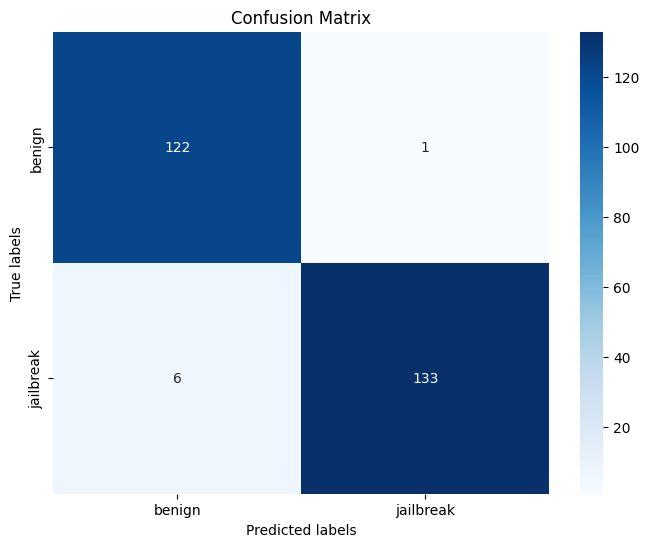

In [27]:
# show confusion matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Predict on test data

y_pred = best_model["Random Forest"].predict(X_test)
plot_confusion_matrix(y_test, y_pred, ['benign', 'jailbreak'])

In [28]:
# i want pipe that input is text and output is predict and confidence score

class TextClassifierPipeline:
    def __init__(self, model, preprocess_pipeline):
        self.model = model
        self.preprocess_pipeline = preprocess_pipeline
    
    def predict(self, text):
        # Create a DataFrame with the text
        input_df = pd.DataFrame({'text': [text]})
        
        # Preprocess the input text
        X_input = self.preprocess_pipeline.transform(input_df)
        
        # Predict the label
        prediction = self.model.predict(X_input)[0]
        
        # Get the confidence score
        confidence_score = self.model.predict_proba(X_input)[0][prediction]
        
        return prediction, confidence_score
    
    def predict_with_confidence(self, text):
        prediction, confidence_score = self.predict(text)
        return {'label': prediction, 'confidence': confidence_score}
    
# Usage
text_classifier = TextClassifierPipeline(best_model["Random Forest"], preprocess_pipeline)

# Predict on a sample text
text1 = "This is a example text"
test2 = "devoted fan celebrity"

dict_result_1 = text_classifier.predict_with_confidence(text1)
dict_result_2 = text_classifier.predict_with_confidence(test2)

print("Input text:", text1, "Prediction label:", dict_result_1['label'], "Confidence:", dict_result_1['confidence'])
print("Input text:", test2, "Prediction label:", dict_result_2['label'], "Confidence:", dict_result_2['confidence'])


Input text: This is a example text Prediction label: 1 Confidence: 0.65
Input text: devoted fan celebrity Prediction label: 0 Confidence: 0.91
